## Workflow to analyze Photometry data

### Imports

In [21]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *


### Variables

In [22]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.getcwd())

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

In [23]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
#pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')

# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)



Saved sessions loaded from: sessions.pkl


In [24]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5')

exp_cohort.save()


KeyboardInterrupt: 

Print valid photometry path of sessions

In [25]:
for s in range(0,len(exp_cohort.sessions)):
    if exp_cohort.sessions[s].photometry_path is not None:
        print(exp_cohort.sessions[s].photometry_path)

\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC282LS-2021-12-03-095324.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC280LS-2021-12-03-105333.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC297PR-2022-01-12-153647.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC291PS-2022-01-12-162841.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC291PS-2022-01-12-162841.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC295LS-2022-01-12-171621.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC289PS-2022-01-13-110008.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC289PS-2022-01-13-112936.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC289PS-2022-01-16-201206.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry\JC290PS-2022-01-16-202342.ppd
\\ettin\Magill_Lab\Julien\Data\head-fixed\test_fol

Select a subset of sessions, here based on the task name and having a valid photometry file

In [26]:
exp_cohort.sessions = [session for session in exp_cohort.sessions if (
    session.task_name == 'reaching_go_nogo') and (session.photometry_path is not None)]

len(exp_cohort.sessions)

108

Perform analysis by trial only on this subset

In [ ]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

No event  'spout'  found:  295 2022-01-12 17:15:29 reaching_go_nogo


Select the subset of sessions for one animal which have photometry trials

In [27]:
sessions_subset = [session for session in exp_cohort.sessions if (
    session.task_name == 'reaching_go_nogo') 
    and (session.photometry_path is not None)
    and (session.subject_ID == 300)]


Processing tests

condition 0 trials: 209


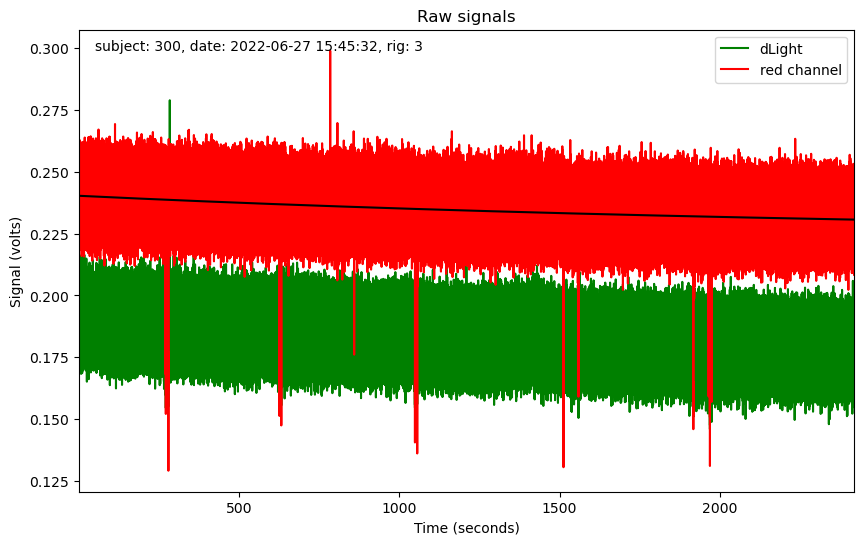

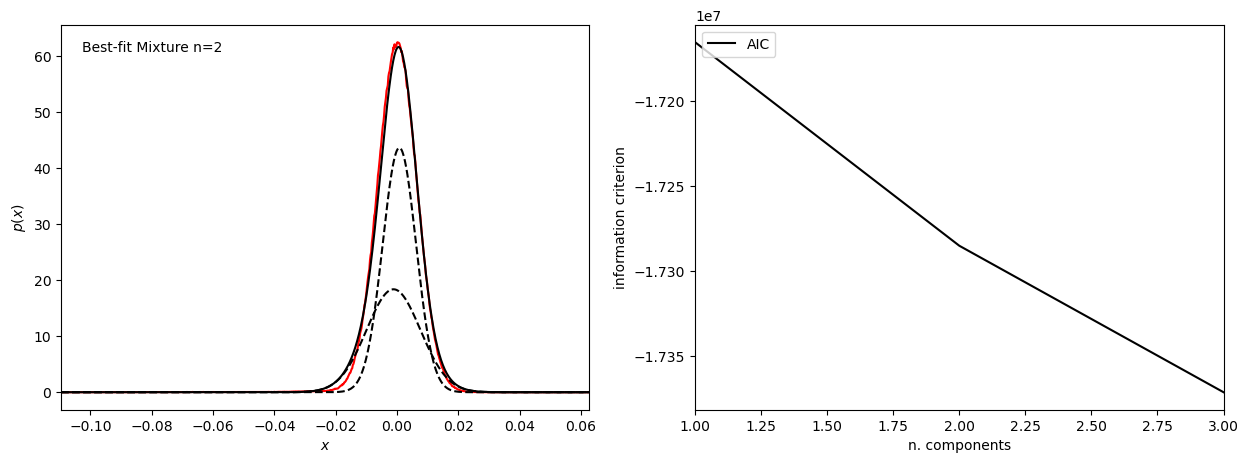

8 trials with artifacts were removed


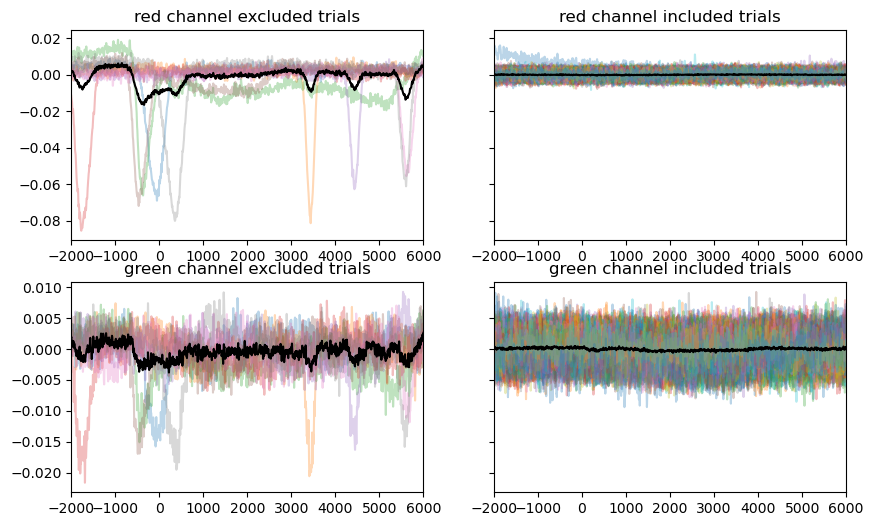

300 2022-06-27 15:45:32  rig: 3


In [54]:
idx = -1
low_pass = 45
high_pass = 0.05
median_filt = 3
motion_corr = True
df_over_f = True
downsampling_factor = None
export_vars = ['analog_1','analog_2','analog_1_filt','analog_2_filt','analog_1_est_motion','analog_1_corrected','analog_1_corrected']

df_meta_photo, col_names_numpy, photo_array, photometry_dict = sessions_subset[idx].get_photometry_trials(
    conditions_list = None, 
    cond_aliases = None,
    trig_on_ev = None, 
    high_pass = high_pass, 
    low_pass = low_pass, 
    median_filt = median_filt, 
    motion_corr = motion_corr, 
    df_over_f = df_over_f, 
    downsampling_factor = downsampling_factor,
    return_full_session = False, 
    export_vars = export_vars,
    remove_artifacts = True,
    verbose = True)

try:
    rig_nb = int(sessions_subset[idx].files['mp4'][0].split('Rig_')[1][0])
except:
    rig_nb = 'unknown'

print(sessions_subset[idx].subject_ID, sessions_subset[idx].datetime, ' rig:', rig_nb)


Testing implementation at Experiment object level

In [30]:
from copy import deepcopy
exp_cohort_subset = deepcopy(exp_cohort)


exp_cohort_subset.sessions = [session for session in exp_cohort.sessions if (
    session.task_name == 'reaching_go_nogo') 
    and (session.photometry_path is not None)
]#and (session.subject_ID == 296)]

exp_cohort_subset.by_trial = True

print(len(exp_cohort_subset.sessions))

108


In [20]:
exp_cohort_subset.process_exp_by_trial(
    trial_window, timelim, tasksfile, blank_spurious_event='spout', blank_timelim=[0, 65],verbose = True)

NameError: name 'exp_cohort_subset' is not defined

### Define conditions and groups for extraction

In [31]:
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 'success': False, 'reward free': False, 'button_press': False}
conditions_dict3 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': True, 'reward free': False, 'button_press': False}
conditions_dict4 = {'trigger': 'CS_NoGo', 'valid': True, 'success': True, 'button_press': False}
conditions_dict5 = {'trigger': 'CS_NoGo', 'valid': True, 'success': False, 'button_press': False}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2, conditions_dict3, conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Go hit', 'Go miss', 'Go hit error', 'NoGo hit', 'NoGo miss']
# Groups as a list of lists
groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

In [165]:
cont_dataset = exp_cohort_subset.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'reaching_go_nogo', #'reaching_go_nogo',
        trig_on_ev = None, # align to the first event of a kind e.g. bar_off
        high_pass = None, 
        low_pass = 45, 
        median_filt = 3,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 10, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f'], 
        remove_artifacts = False,
        verbose = True) # will plot all the process of remove_artifacts if remove_artifacts == True

cont_dataset.set_trial_window(trial_window, 'ms')

[autoreload of trialexp.dataset_classes.trial_dataset_classes failed: Traceback (most recent call last):
  File "c:\Users\phar0732\.conda\envs\trialexp\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\phar0732\.conda\envs\trialexp\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "c:\Users\phar0732\.conda\envs\trialexp\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "c:\users\phar0732\documents\github\trialexp\trialexp\dataset_classes\trial_dataset_classes.py", line 907, in <module>
    class Event_Dataset(Trials_Dataset):
  File "c:\users\phar0732\documents\github\trialexp\trialexp\dataset_

Processing subject 280 at: 2021-12-03 10:41:38
condition 0 trials: 88
condition 1 trials: 7
condition 2 trials: 0
condition 3 trials: 30
condition 4 trials: 4
Processing subject 282 at: 2021-12-03 09:53:26
condition 0 trials: 90
condition 1 trials: 20
condition 2 trials: 0
condition 3 trials: 54
condition 4 trials: 0
Processing subject 289 at: 2022-01-13 11:00:10
condition 0 trials: 8
condition 1 trials: 4
condition 2 trials: 0
condition 3 trials: 18
condition 4 trials: 22
Processing subject 289 at: 2022-01-13 11:29:37
condition 0 trials: 0
condition 1 trials: 0
condition 2 trials: 0
condition 3 trials: 3
No trial in any condition for subject 289 at: 2022-01-13 11:29:37
Processing subject 289 at: 2022-01-16 20:12:08
condition 0 trials: 9
condition 1 trials: 6
condition 2 trials: 0
condition 3 trials: 33
condition 4 trials: 8
Processing subject 289 at: 2022-03-11 09:00:02
condition 0 trials: 19
condition 1 trials: 22
condition 2 trials: 0
condition 3 trials: 4
condition 4 trials: 1
Proc

c:\Users\phar0732\.conda\envs\trialexp\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Estimated number of clusters: 3
Estimated number of noise points: 356
Silhouette Coefficient: 0.511
samples per cluster:   0    10452
-1      356
 1      242
 2       11
dtype: int64


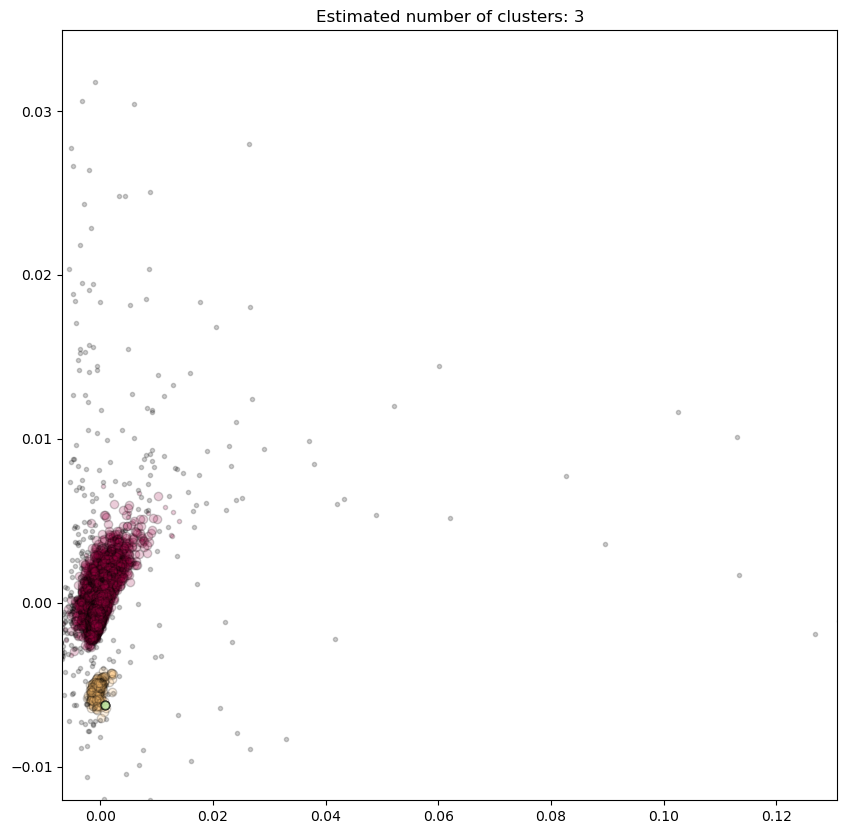

In [171]:
cont_dataset.cluster_trials()

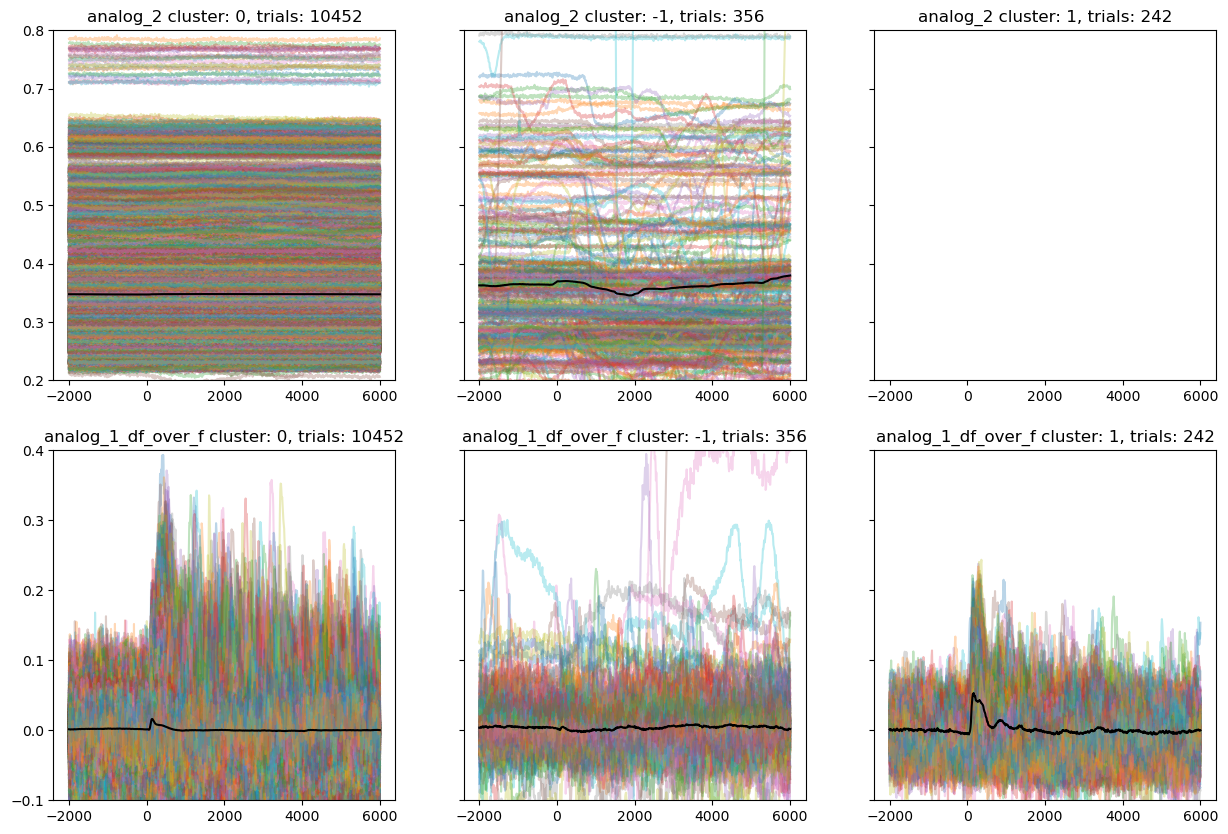

In [172]:
cont_dataset.plot_clustered_trials()

In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cluster import DBSCAN
from sklearn import metrics

def DBSCAN_cluster_on_compoonents(
        np_comp: np.ndarray, 
        eps: float, 
        min_samples: int,
        plot: bool = True,
        plot_lim_pctile: float = 0.1
        ):
        
    db = DBSCAN(eps=eps, min_samples=10).fit(np_comp)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    # print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    # print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    # print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    # print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
    # print(
    #     "Adjusted Mutual Information: %0.3f"
    #     % metrics.adjusted_mutual_info_score(labels_true, labels)
    #)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(np_comp, labels))

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    if plot:
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

        fig, axs = plt.subplots(1,1, figsize=(10,10))

        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = labels == k

            xy = np_comp[class_member_mask & core_samples_mask]
            axs.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6,
                alpha=0.2
            )

            xy = np_comp[class_member_mask & ~core_samples_mask]
            axs.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=3,
                alpha=0.2
            )

    axs.set_title("Estimated number of clusters: %d" % n_clusters_)
    xlim = [np.percentile(np_comp[:,0],plot_lim_pctile), np.percentile(np_comp[:,0],100-plot_lim_pctile)]
    ylim = [np.percentile(np_comp[:,1],plot_lim_pctile), np.percentile(np_comp[:,1],100-plot_lim_pctile)]
    
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)

    pd_labels = pd.Series(labels)
    print('samples per cluster: ', pd_labels.value_counts())

    return labels

def extract_feature_components(panel_df,
        variable: str = 'analog_2', 
        type: str = 'PCA', 
        scaled: bool = True,
        plot: bool = False,
        plot_lim_pctile: float = 0.1
        ):
    
    df_feat = ts_to_features(panel_df[variable])

    if scaled:

        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df_feat)

    else:
        df_scaled = df_feat
    
    if type == 'PCA':
        
        comp_obj = PCA(n_components = df_scaled.shape[1])
    
    if type == 'ICA':
        
        comp_obj = FastICA(n_components = df_scaled.shape[1])

    
    np_comp = comp_obj.fit_transform(df_scaled)

    if plot:
        fig, axs = plt.subplots(1,1, figsize=(10,10))
        axs.scatter(np_comp[:,0],np_comp[:,1],marker='o', s=7, alpha=0.1)
        xlim = [np.percentile(np_comp[:,0],plot_lim_pctile), np.percentile(np_comp[:,0],100-plot_lim_pctile)]
        ylim = [np.percentile(np_comp[:,1],plot_lim_pctile), np.percentile(np_comp[:,1],100-plot_lim_pctile)]
        
        axs.set_xlim(xlim)
        axs.set_ylim(ylim)
        return np_comp, axs
    
    else: 
        return np_comp

def ts_to_features(ts):
    # progress_apply exists after running tqdm.pandas() and yields a progress bar
    return pd.DataFrame(ts.apply(feature_extraction).tolist())

def feature_extraction(x):
    # no corr() or cov() because it is a single variate time series
    return {
        #"mean": x.mean(),
        "median": x.median(),
        "max-min": x.max() - x.min(),
        "var": x.var(),
        "std": x.std(),
        "kurt": x.kurt(),
        "skew": x.skew()
    }



In [137]:
df_comp = extract_feature_components(panel_full_data, variable='analog_2_filt', type = 'ICA', plot = False)

c:\Users\phar0732\.conda\envs\trialexp\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Estimated number of clusters: 3
Estimated number of noise points: 362
Silhouette Coefficient: 0.462
samples per cluster:   0    10446
-1      362
 1      242
 2       11
dtype: int64


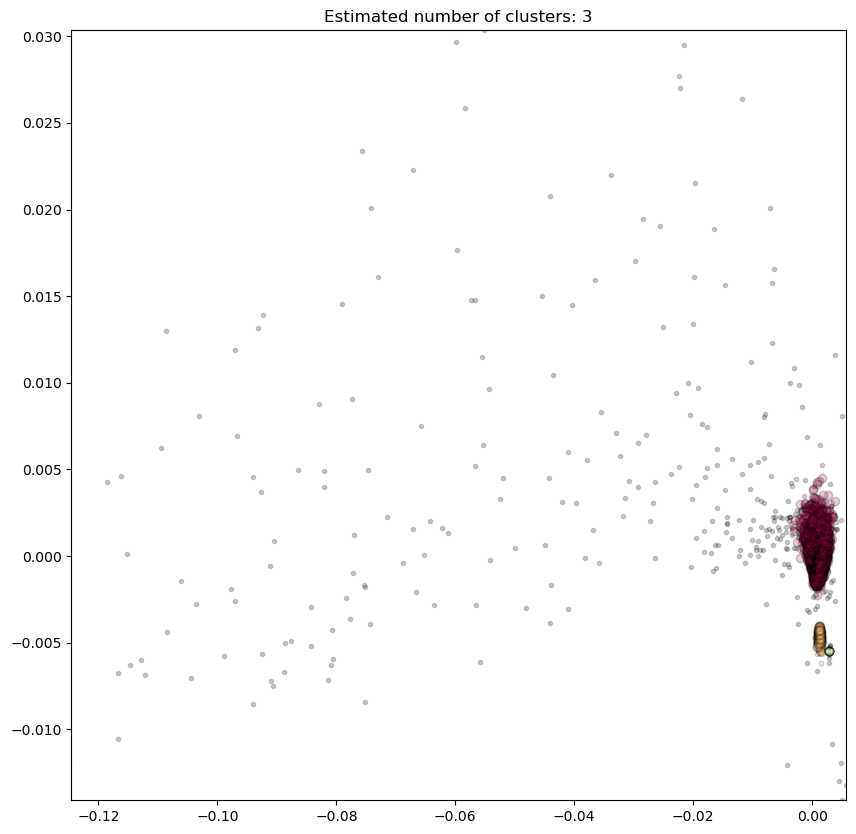

In [163]:
labels  = DBSCAN_cluster_on_compoonents(
        np_comp = df_comp, 
        eps =  0.005, 
        min_samples =  50,
        plot = True,
        plot_lim_pctile = 0.1)

In [150]:
pd_labels = pd.Series(labels)
clusters_size = pd_labels.value_counts().to_dict()
min_cluster_size_to_plot = 20

clusters_size = {k: v for (k, v) in clusters_size.items() if (v >= min_cluster_size_to_plot)}

labels == 1

array([False, False, False, ..., False, False, False])

In [164]:
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

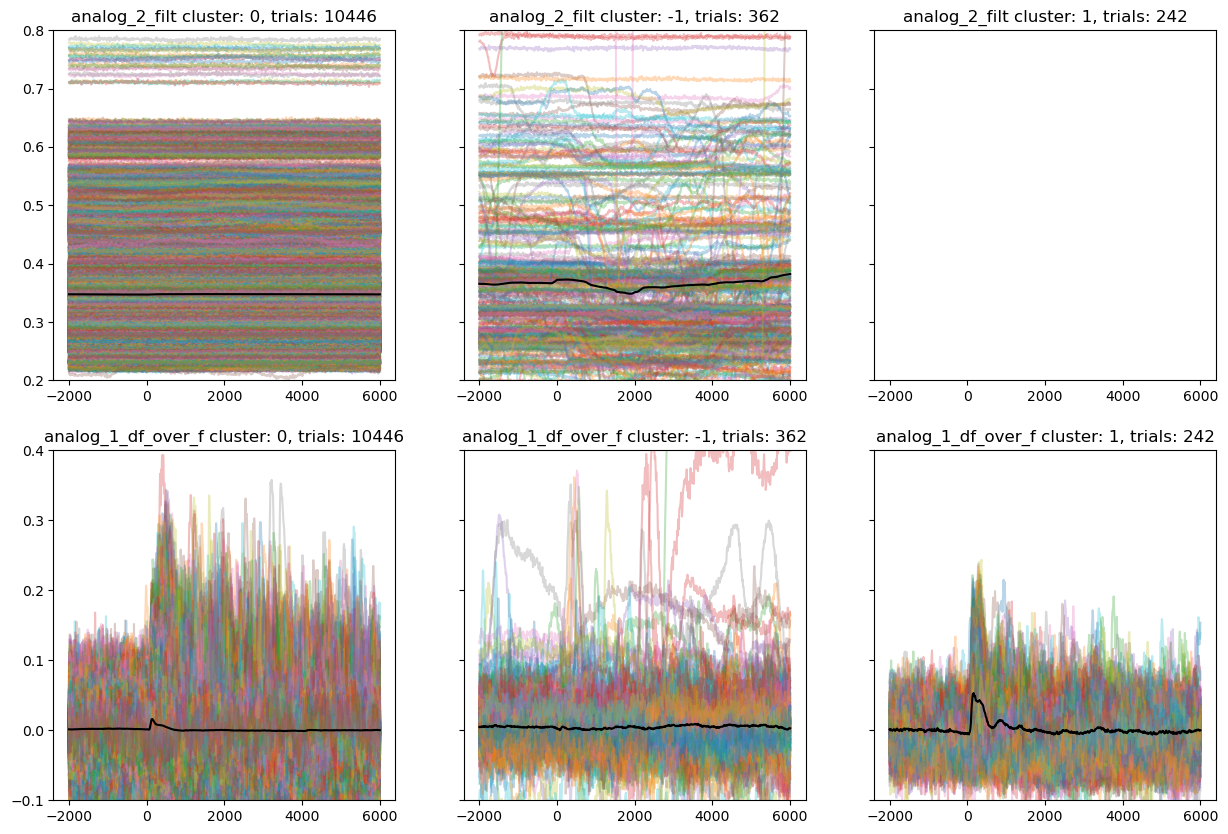

In [160]:
plot_clustered_trials(
        cont_dataset,
        labels, 
        vars_to_plot = ['analog_2_filt','analog_1_df_over_f'],
        min_cluster_size_to_plot = 20,
        ylims = [[0.2,0.8],[-0.1,0.4]])

Define parameters of feature extraction

In [1]:
from tsfresh.feature_extraction.settings import EfficientFCParameters
tsfresh_params = EfficientFCParameters()

features_to_calc = [
    'absolute_sum_of_changes',
    'absolute_maximum',
    'agg_linear_trend',
    'large_standard_deviation',
    'longest_strike_above_mean',
    'longest_strike_below_mean',
    'mean_abs_change',
    'mean_change',
    'quantile',
    'variance_larger_than_standard_deviation',
    'variance',
]

features_dict = dict.fromkeys(features_to_calc, None)
features_dict

{'absolute_sum_of_changes': None,
 'absolute_maximum': None,
 'agg_linear_trend': None,
 'large_standard_deviation': None,
 'longest_strike_above_mean': None,
 'longest_strike_below_mean': None,
 'mean_abs_change': None,
 'mean_change': None,
 'quantile': None,
 'variance_larger_than_standard_deviation': None,
 'variance': None}

In [16]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
tsfresh = TSFreshFeatureExtractor(default_fc_parameters = features_dict )

tsfresh.default_fc_parameters

set default parameter if None


KeyError: 'kind_to_fc_parameters'

In [550]:
tsfresh.default_fc_parameters

{'absolute_sum_of_changes': None,
 'absolute_maximum': None,
 'agg_linear_trend': None,
 'large_standard_deviation': None,
 'longest_strike_above_mean': None,
 'longest_strike_below_mean': None,
 'mean_abs_change': None,
 'mean_change': None,
 'quantile': None,
 'variance_larger_than_standard_deviation': None,
 'variance': None}

In [557]:

X_transform_custom = tsfresh.fit_transform(panel_full_data.iloc[:100,:])
X_transform_custom

set default parameter if None



KeyboardInterrupt



In [ ]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
tsfresh = TSFreshFeatureExtractor(kind_to_fc_parameters=features_dict)


X_transform = tsfresh.fit_transform(panel_data)
X_transform

In [520]:
X_transform_full.shape

(11061, 1566)

In [514]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn import metrics

pca = PCA(n_components = 10)
ica = FastICA(n_components = 10)
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()


X_scaled = scaler.fit_transform(X_transform_full)
X_pca = pca.fit_transform(X_scaled)
X_ica = ica.fit_transform(X_scaled)
# pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca)])


c:\Users\phar0732\.conda\envs\trialexp\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Tsne Computation

In [518]:
tsne_pca = TSNE(n_components=2, learning_rate='auto',
    init='random', perplexity=5).fit_transform(X_pca)

tsne_ica = TSNE(n_components=2, learning_rate='auto',
    init='random', perplexity=5).fit_transform(X_ica)    

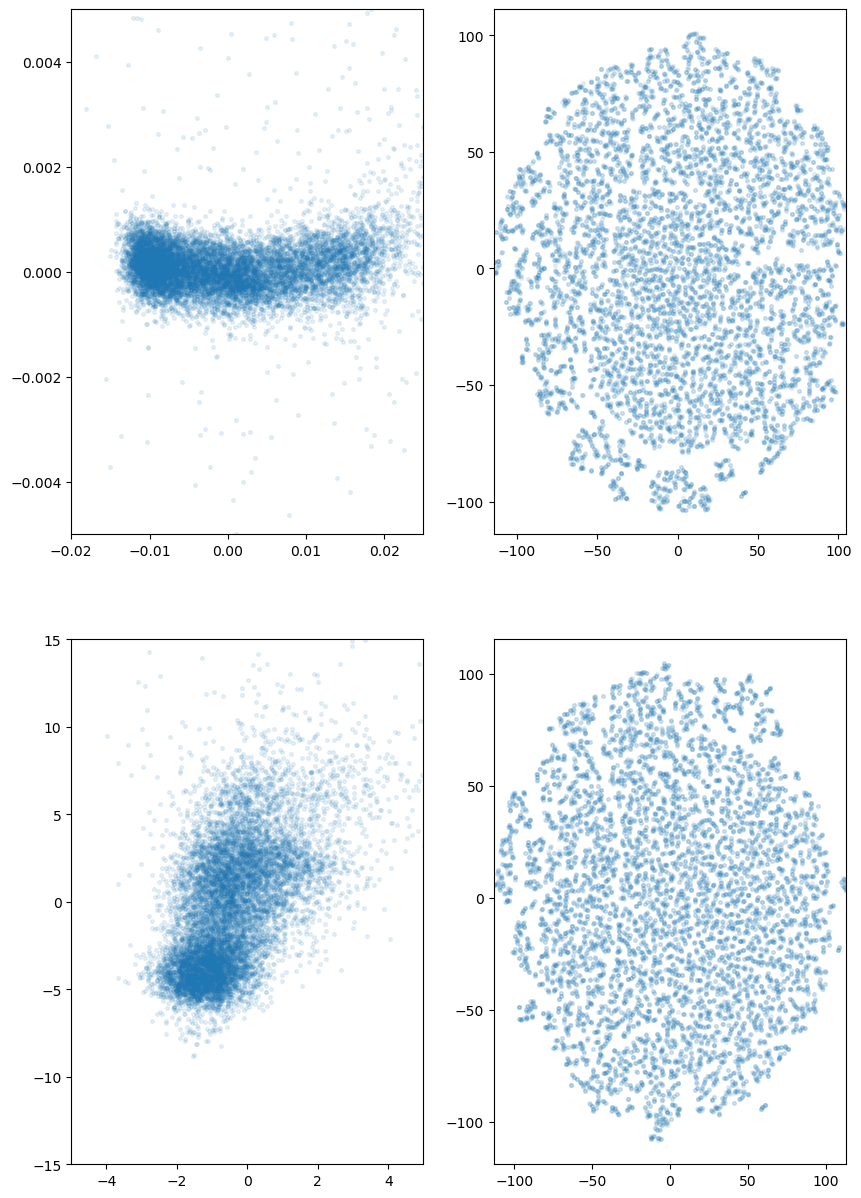

In [519]:
fig, axs = plt.subplots(2,2, figsize=(10,15))

axs[0,0].scatter(X_ica[:,0],X_ica[:,1],marker='o', s=7, alpha=0.1)
axs[0,0].set_xlim([-0.02,0.025])
axs[0,0].set_ylim([-0.005,0.005])

axs[1,0].scatter(X_pca[:,0],X_pca[:,1],marker='o', s=7, alpha=0.1)
axs[1,0].set_xlim([-5,5])
axs[1,0].set_ylim([-15,15])


axs[0,1].scatter(tsne_pca[:,0],tsne_pca[:,1],marker='o', s=7, alpha=0.1)
# axs[0,1].set_xlim([-0.02,0.025])
# axs[0,1].set_ylim([-0.005,0.005])

axs[1,1].scatter(tsne_ica[:,0],tsne_ica[:,1],marker='o', s=7, alpha=0.1)
# axs[1,1].set_xlim([-5,5])
# axs[1,1].set_ylim([-15,15])

Estimated number of clusters: 2
Estimated number of noise points: 264
Silhouette Coefficient: 0.669


 0    10555
-1      264
 1      242
dtype: int64

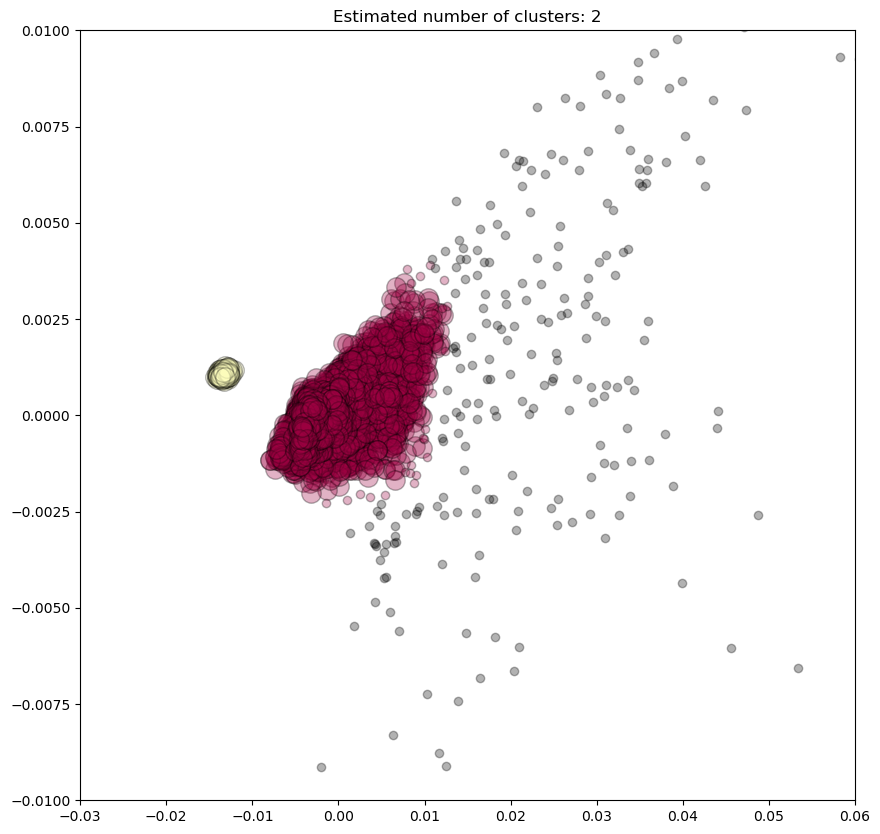

In [506]:
import matplotlib.pyplot as plt

db = DBSCAN(eps=0.001, min_samples=10).fit(X_ica)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_ica, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, axs = plt.subplots(1,1, figsize=(10,10))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X_ica[class_member_mask & core_samples_mask]
    axs.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
        alpha=0.3
    )

    xy = X_ica[class_member_mask & ~core_samples_mask]
    axs.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
        alpha=0.3
    )

axs.set_title("Estimated number of clusters: %d" % n_clusters_)
axs.set_xlim([-0.03,0.06])
axs.set_ylim([-0.01,0.01])

pd_labels = pd.Series(labels)
pd_labels.value_counts()

Estimated number of clusters: 2
Estimated number of noise points: 107
Silhouette Coefficient: 0.970


 0    10944
-1      107
 1       10
dtype: int64

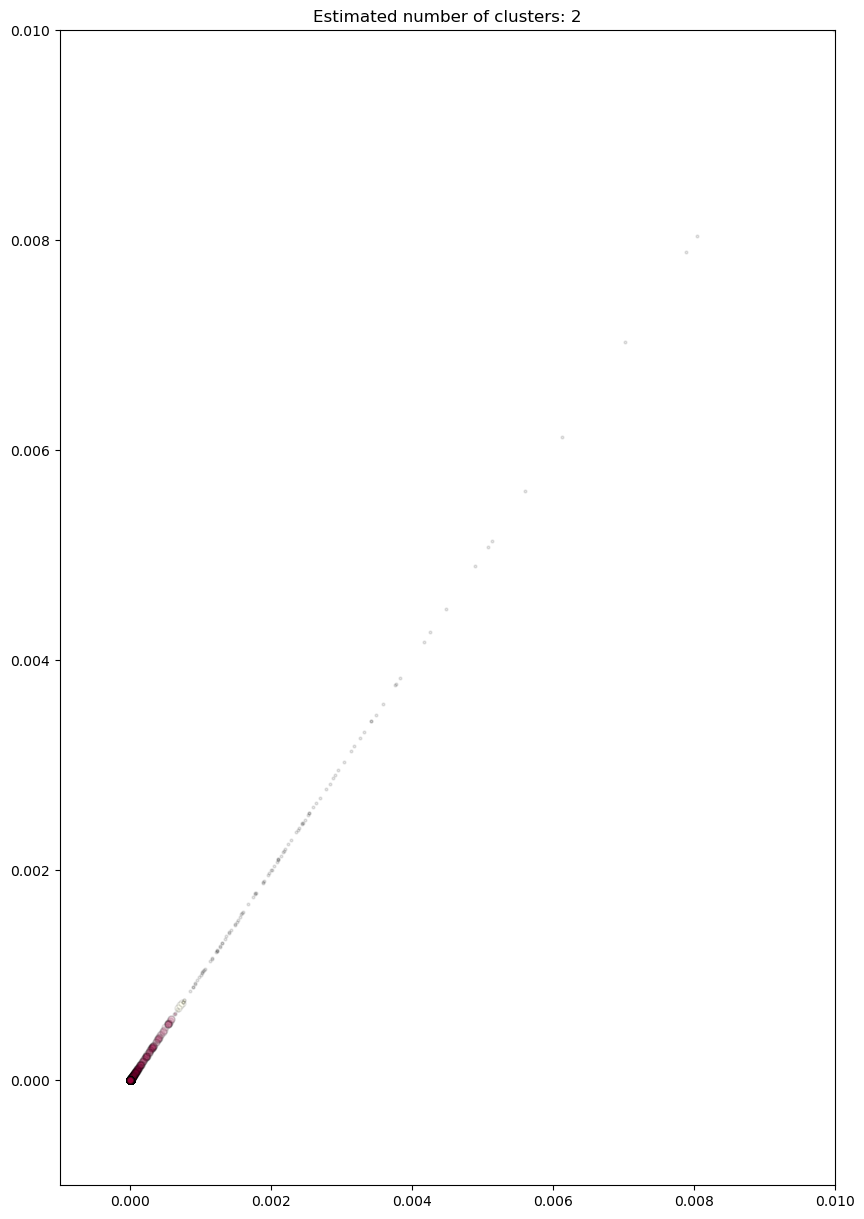

In [493]:
import matplotlib.pyplot as plt

data_var = np.vstack([var,var1]).T

db = DBSCAN(eps=0.0001, min_samples=10).fit(data_var)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data_var, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, axs = plt.subplots(1,1, figsize=(10,15))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = data_var[class_member_mask & core_samples_mask]
    axs.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=5,
        alpha=0.1
    )

    xy = data_var[class_member_mask & ~core_samples_mask]
    axs.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=2,
        alpha=0.1
    )

axs.set_title("Estimated number of clusters: %d" % n_clusters_)
axs.set_xlim([-0.001,0.01])
axs.set_ylim([-0.001,0.01])

pd_labels = pd.Series(labels)
pd_labels.value_counts()


In [477]:
X_ica.shape

(11061, 2)

In [478]:
varmat = np.vstack([var1,var2])

In [398]:
cont_dataset.data[trials_to_exclude, cont_dataset.colnames_dict['analog_2_filt'],:].shape
print(cont_dataset.colnames_dict,cont_dataset.data.shape)

{'analog_2': 0, 'analog_1': 1, 'analog_1_df_over_f': 2, 'analog_2_filt': 3, 'analog_1_filt': 4} (1354, 5, 800)


In [411]:
def

array([False, False, False, ..., False, False, False])

In [498]:
cont_dataset.data[trials_cluster1,cont_dataset.colnames_dict['analog_1_df_over_f'],:].T

array([[ 0.00975353, -0.03281833,  0.02640509, ..., -0.03367795,
        -0.0319719 , -0.01345221],
       [-0.02554591, -0.01015686,  0.01706363, ..., -0.04408607,
         0.00131278, -0.02476164],
       [-0.0149585 , -0.00482326, -0.00050868, ..., -0.03195895,
        -0.0097226 , -0.03551969],
       ...,
       [-0.03530794, -0.02897929, -0.02283766, ..., -0.04910062,
        -0.04469451,  0.00578684],
       [-0.04741258, -0.02348071, -0.01010767, ..., -0.04208288,
        -0.05159225,  0.02512829],
       [-0.03745142, -0.02090993,  0.0042655 , ..., -0.01152333,
        -0.06632426,  0.01667708]])

(-0.5, 0.5)

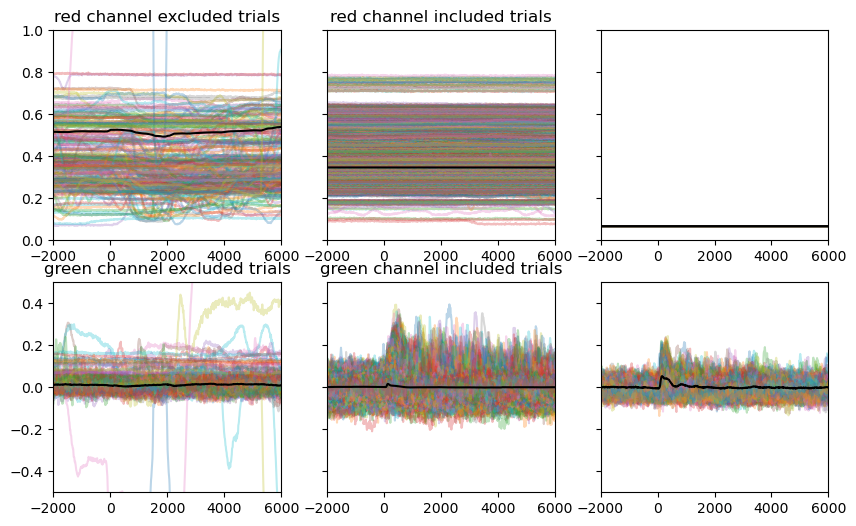

In [507]:
# trials_to_exclude = np.logical_or(labels == 1, labels == 1)
trials_to_exclude = labels == -1
trials_to_include = labels == 0
trials_cluster1 = labels == 1


fig, axs = plt.subplots(nrows=2, ncols=3, sharey='row')
timevec_trial = np.linspace(cont_dataset.trial_window[0], cont_dataset.trial_window[1], cont_dataset.data.shape[2])

_ = axs[0,0].plot(timevec_trial, cont_dataset.data[trials_to_exclude,cont_dataset.colnames_dict['analog_2_filt'],:].T, alpha=0.3)
_ = axs[0,0].plot(timevec_trial, cont_dataset.data[trials_to_exclude,cont_dataset.colnames_dict['analog_2_filt'],:].mean(0), c='k', alpha=1)

_ = axs[0,1].plot(timevec_trial, cont_dataset.data[trials_to_include,cont_dataset.colnames_dict['analog_2_filt'],:].T, alpha=0.3)
_ = axs[0,1].plot(timevec_trial, cont_dataset.data[trials_to_include,cont_dataset.colnames_dict['analog_2_filt'],:].mean(0), c='k', alpha=1)

_ = axs[0,2].plot(timevec_trial, cont_dataset.data[trials_cluster1,cont_dataset.colnames_dict['analog_2_filt'],:].T, alpha=0.3)
_ = axs[0,2].plot(timevec_trial, cont_dataset.data[trials_cluster1,cont_dataset.colnames_dict['analog_2_filt'],:].mean(0), c='k', alpha=1)

_ = axs[1,0].plot(timevec_trial, cont_dataset.data[trials_to_exclude,cont_dataset.colnames_dict['analog_1_df_over_f'],:].T, alpha=0.3)
_ = axs[1,0].plot(timevec_trial, cont_dataset.data[trials_to_exclude,cont_dataset.colnames_dict['analog_1_df_over_f'],:].mean(0), c='k', alpha=1)

_ = axs[1,1].plot(timevec_trial, cont_dataset.data[trials_to_include,cont_dataset.colnames_dict['analog_1_df_over_f'],:].T, alpha=0.3)
_ = axs[1,1].plot(timevec_trial, cont_dataset.data[trials_to_include,cont_dataset.colnames_dict['analog_1_df_over_f'],:].mean(0), c='k', alpha=1)

_ = axs[1,2].plot(timevec_trial, cont_dataset.data[trials_cluster1,cont_dataset.colnames_dict['analog_1_df_over_f'],:].T, alpha=0.3)
_ = axs[1,2].plot(timevec_trial, cont_dataset.data[trials_cluster1,cont_dataset.colnames_dict['analog_1_df_over_f'],:].mean(0), c='k', alpha=1)



axs[0,0].set_title('red channel excluded trials')
axs[0,1].set_title('red channel included trials')

axs[1,0].set_title('green channel excluded trials')
axs[1,1].set_title('green channel included trials')

axs[0,0].set_ylim([0,1])
axs[1,0].set_ylim([-0.5,0.5])

In [459]:
cont_dataset.data[:,cont_dataset.colnames_dict['analog_1_df_over_f'],:].var(1).shape

(11061,)

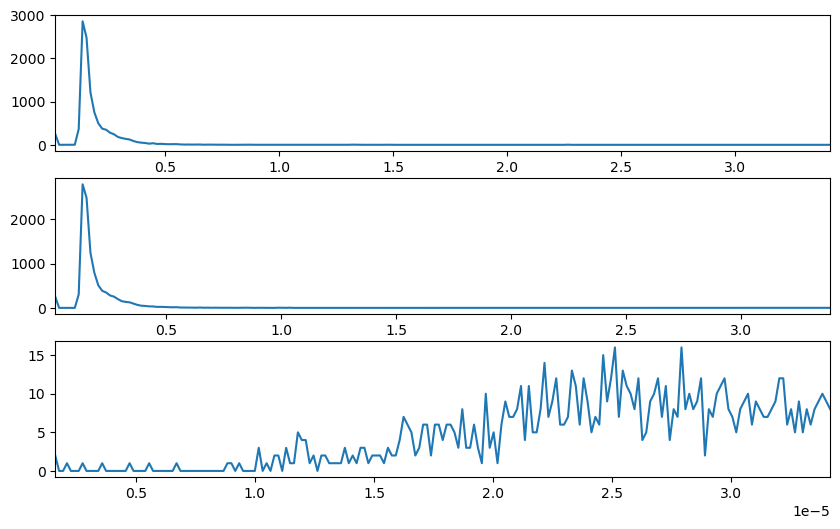

In [470]:


fig, axs = plt.subplots(nrows=3, ncols=1, sharey='row')

data = cont_dataset.data[:,cont_dataset.colnames_dict['analog_2_filt'],:]

var = data.var(1)
var_qtile = (np.percentile(var,0),np.percentile(var,98))
count, bins = np.histogram(var,bins= np.arange(var_qtile[0],var_qtile[1], (var_qtile[1]-var_qtile[0])/200))

axs[0].plot(bins[1:]/2,count)

data = cont_dataset.data[:,cont_dataset.colnames_dict['analog_2'],:]

var1 = data.var(1)
var_qtile = (np.percentile(var1,0),np.percentile(var1,98))
count, bins = np.histogram(var1,bins= np.arange(var_qtile[0],var_qtile[1], (var_qtile[1]-var_qtile[0])/200))

axs[1].plot(bins[1:]/2,count)

data = cont_dataset.data[:,cont_dataset.colnames_dict['analog_1_df_over_f'],:]

var2 = data.var(1)
var_qtile = (np.percentile(var2,0),np.percentile(var,98))
count, bins = np.histogram(var2,bins= np.arange(var_qtile[0],var_qtile[1], (var_qtile[1]-var_qtile[0])/200))

axs[2].plot(bins[1:]/2,count)

In [433]:
def(cont_dataset)

(-0.25, 0.25)

In [178]:
cont_dataset.data

analog_2  \
0     0      0.340838
1      0.339749
2      0.33861...   
1     0      0.337692
1      0.335198
2      0.33460...   
2     0      0.337982
1      0.333641
2      0.33156...   
3     0      0.330902
1      0.327496
2      0.32571...   
4     0      0.327404
1      0.327233
2      0.32797...   
...                                                 ...   
1349  0      0.273927
1      0.272208
2      0.27388...   
1350  0      0.276353
1      0.277728
2      0.27828...   
1351  0      0.280046
1      0.281126
2      0.28126...   
1352  0      0.276945
1      0.278132
2      0.27747...   
1353  0      0.274942
1      0.277571
2      0.27724...   

                                          analog_2_filt  
0     0      0.341205
1      0.339267
2      0.33916...  
1     0      0.337396
1      0.335466
2      0.33550...  
2     0      0.337601
1      0.334621
2      0.33173...  
3     0      0.331186
1      0.328348
2      0.32682...  
4     0      0.327145
1      0.325660
2      0.32657...  
...                                                 ...  
1349  0      0.274452
1      0.272149
2      0.27251...  
1350  0      0.275485
1      0.276849
2      0.27845...  
1351  0      0.278784
1      0.280996
2      0.28097...  
1352  0      0.276860
1      0.277846
2      0.27713...  
1353  0      0.275550
1      0.278171
2      0.27874...  

[1354 rows x 2 columns]

In [ ]:
from tsfresh import extract_features
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")


Plotting raw signals

In [12]:
import pylab as plt
plt.rcParams['figure.figsize'] = [10, 6] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

In [47]:
from scipy.optimize import curve_fit
# The exponential curve we are going to fit.
def exp_func(x, a, b, c):
   return a*np.exp(-b*x) + c

time = np.linspace(1/1000, len(photometry_dict['analog_1'])/1000, len(photometry_dict['analog_1']))

# ana_1_params, parm_cov = curve_fit(exp_func, time, medfilt(photometry_dict['analog_1'],3), p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
# photometry_dict['analog_1_expfit'] = exp_func(time, *ana_1_params)

ana_2_params, parm_cov = curve_fit(exp_func, time, medfilt(photometry_dict['analog_2'],3), p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
photometry_dict['analog_2_expfit'] = exp_func(time, *ana_2_params)

TypeError: 'int' object is not subscriptable

In [670]:
xlim = [480,800] # [2475,2505]#[0,3500] # [2340,2350]
ylim = [0.10, 0.35]

TypeError: 'int' object is not subscriptable

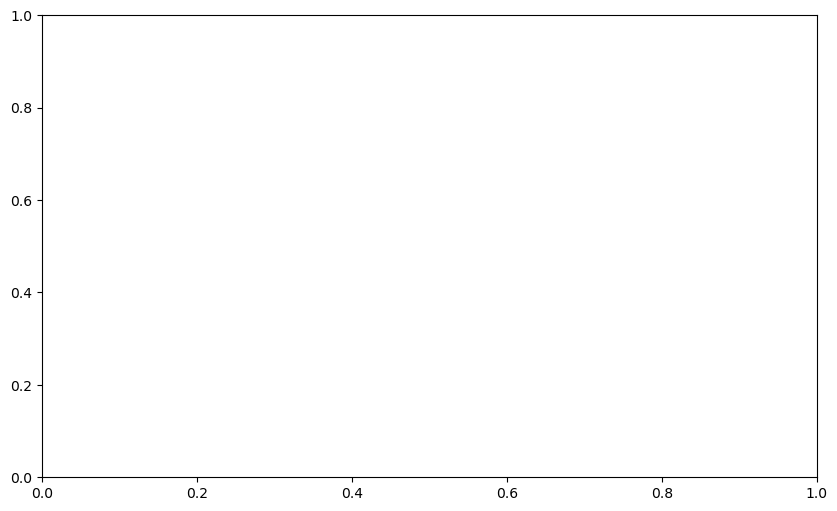

In [46]:
fig, ax = plt.subplots()

plt.plot(time, photometry_dict['analog_1'], 'g', label='dLight')
plt.plot(time, photometry_dict['analog_2'], 'r', label='red channel')
# plt.plot(time, photometry_dict['analog_1_expfit'], 'k')
plt.plot(time, photometry_dict['analog_2_expfit'], 'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Raw signals')
ax.text(0.02, 0.98, f'subject: {sessions_subset[idx].subject_ID}, date: {sessions_subset[idx].datetime}, rig: {rig_nb}',
        ha='left', va='top', transform=ax.transAxes)
# plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

The data will be the signal on the control channel minus its exponential fit.  
Artifacted periods, if they exist, are expected to create a lower gaussian distribution, whereas the main distribution will be at higher red channel values (no shadow)

In [672]:
data = medfilt(photometry_dict['analog_2'],3) - photometry_dict['analog_2_expfit']
# data = medfilt(photometry_dict['analog_2'],3)

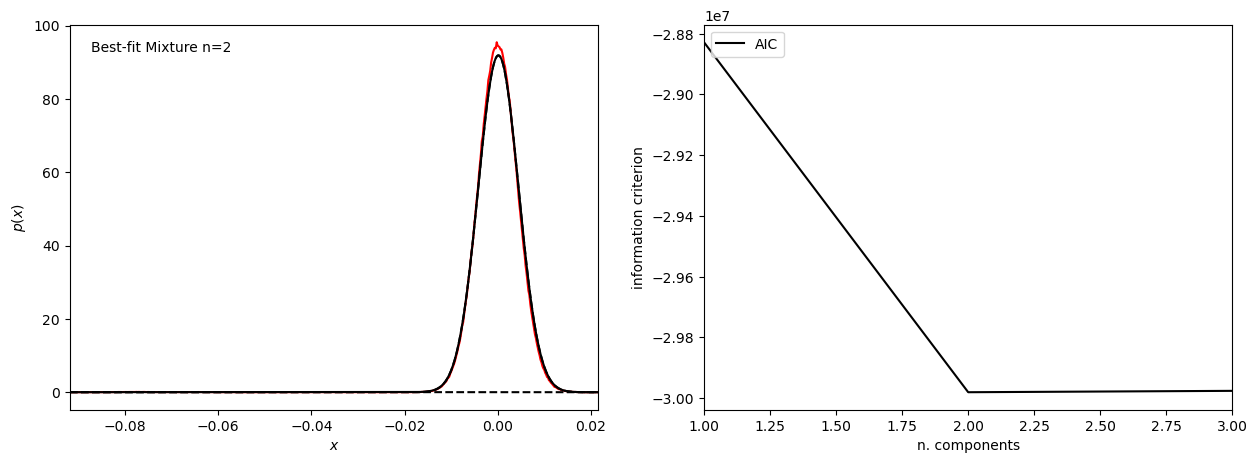

In [673]:
# Original author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#------------------------------------------------------------
# Set up the dataset. 

X = data.reshape(-1, 1)

# (original code: We'll create our dataset by drawing samples from Gaussians)
# random_state = np.random.RandomState(seed=1)

# X = np.concatenate([random_state.normal(-1, 1.5, 350),
#                     random_state.normal(0, 1, 500),
#                     random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 4)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
# BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(15, 5))
# fig.subplots_adjust(left=0.12, right=0.97,
#                     bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(121)

# Original part, take the min of AIC to determine how many gaussians
# M_best = models[np.argmin(AIC)]

# Customized part tweaked to reduce the nb of gaussian used to the minimum
diff_AIC = np.diff(AIC)
if diff_AIC[0] > 0:
    n_best = 0
else:
    n_best = np.where(diff_AIC == min(diff_AIC))[0][0]+1
    
M_best = models[n_best]
# end of customized part

p, bins = np.histogram(X, bins=np.arange(min(X),max(X),0.0002), density=True)

x = bins
logprob = M_best.score_samples(x.reshape(-1, 1))
# logprob = M_best.score_samples(x)

responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.plot(x[:-1], p, 'r') # approximation
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, f'Best-fit Mixture n={n_best+1}',
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
# ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)

plt.show()

In [674]:
M_best.means_

array([[-0.04545856],
       [ 0.0001119 ]])

In [675]:
M_best.covariances_

array([[[9.37182719e-04]],

       [[1.87669723e-05]]])

Only compute variance of red channel for all trials and fix arbitrary threshold

Text(0.5, 0, 'trials')

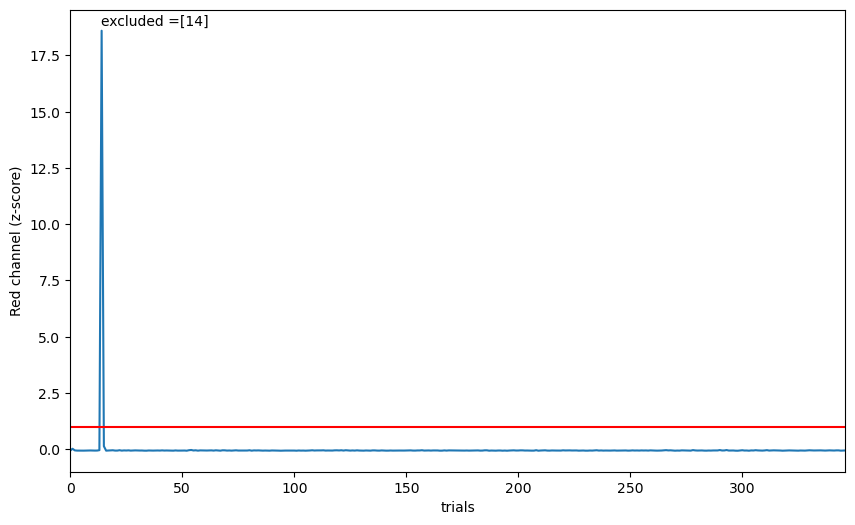

In [676]:
from scipy.stats import zscore

z_thresh = 1

fig, ax = plt.subplots()
var_trials = photo_array[:,col_names_numpy['analog_2_filt']].var(1)
zscore_var = zscore(var_trials)
trials_to_exclude = [idx for idx, v in enumerate(zscore_var) if v > z_thresh]
trials_to_include = [idx for idx, v in enumerate(zscore_var) if v < z_thresh]

# plt.plot(var_trials)
plt.plot(zscore_var)
plt.axhline(z_thresh,c='r')
plt.text(0.04, 0.96, f'excluded ={trials_to_exclude}',
        ha='left', va='bottom', transform=ax.transAxes)
plt.ylabel('Red channel (z-score)')
plt.xlabel('trials')

Plot excluded and included trials in filtered Red and Green channels

NameError: name 'trials_to_exclude' is not defined

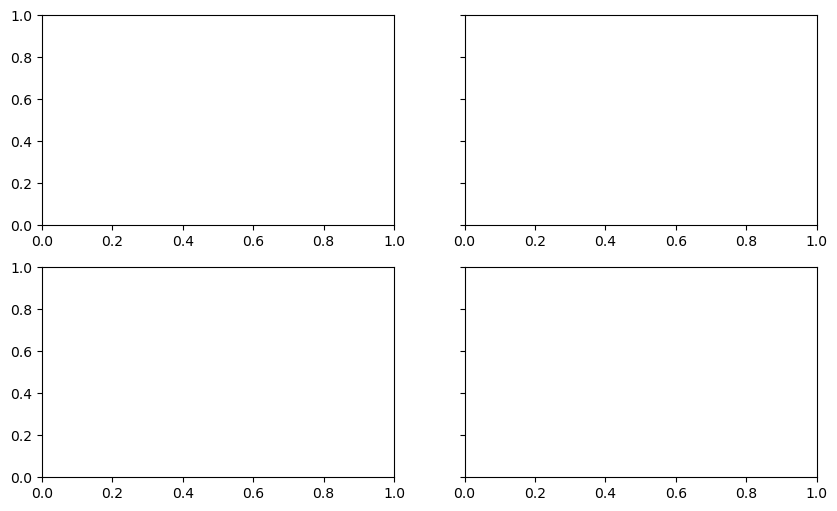

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey='row')
timevec_trial = np.linspace(sessions_subset[idx].trial_window[0], sessions_subset[idx].trial_window[1], photo_array.shape[2])

_ = axs[0,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_2_filt']].T, alpha=0.3)
_ = axs[0,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_2_filt']].mean(0), c='k', alpha=1)

_ = axs[0,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_2_filt']].T, alpha=0.3)
_ = axs[0,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_2_filt']].mean(0), c='k', alpha=1)

_ = axs[1,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_1_filt']].T, alpha=0.3)
_ = axs[1,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_1_filt']].mean(0), c='k', alpha=1)
_ = axs[1,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_1_filt']].T, alpha=0.3)
_ = axs[1,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_1_filt']].mean(0), c='k', alpha=1)

axs[0,0].set_title('red channel excluded trials')
axs[0,1].set_title('red channel included trials')

axs[1,0].set_title('green channel excluded trials')
axs[1,1].set_title('green channel included trials')



In [678]:
photo_array[:,col_names_numpy['analog_2']].var()

0.00018886086899259292

In [411]:
from numpy.lib.stride_tricks import sliding_window_view

v = sliding_window_view(data, 8000, 0)
print(data.shape, v.shape)

v[:,1].shape

(2215700,) (2207701, 8000)


(2207701,)

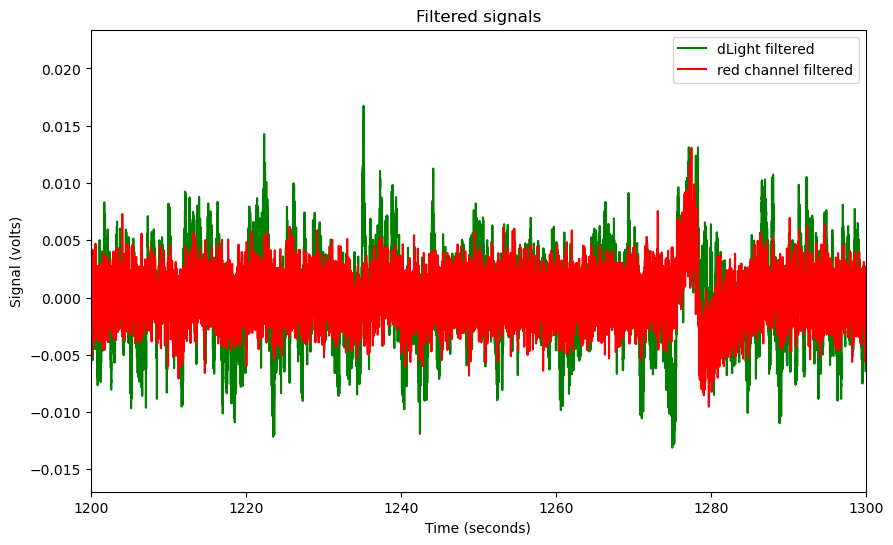

In [394]:
xlim = [1200,1300]
plt.plot(time, photometry_dict['analog_1_filt'], 'g', label='dLight filtered')
plt.plot(time, photometry_dict['analog_2_filt'], 'r', label='red channel filtered')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

In [ ]:
#Gaussian least-square fitting process
param_optimised,param_covariance_matrix = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)

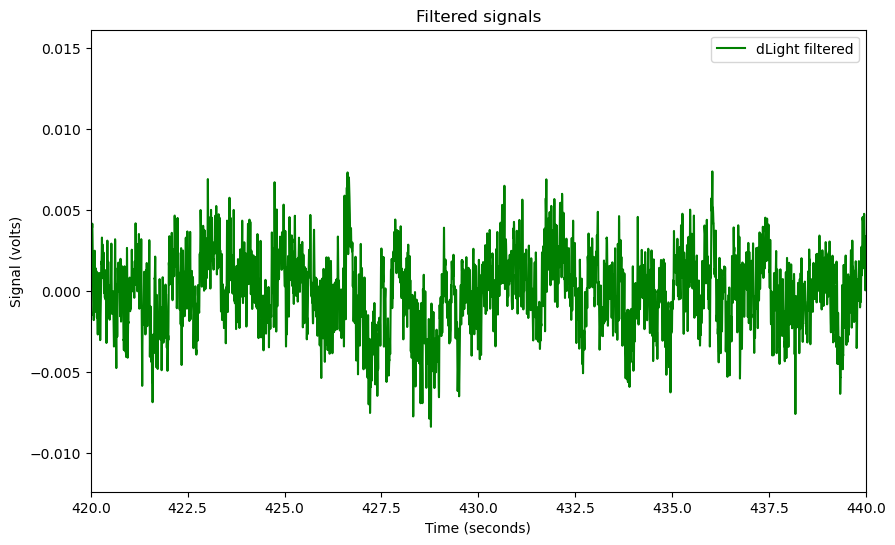

In [184]:

plt.plot(time, photometry_dict['analog_1_filt'], 'g', label='dLight filtered')
# plt.plot(time, photometry_dict['analog_2_filt'], 'r', label='red channel filtered')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

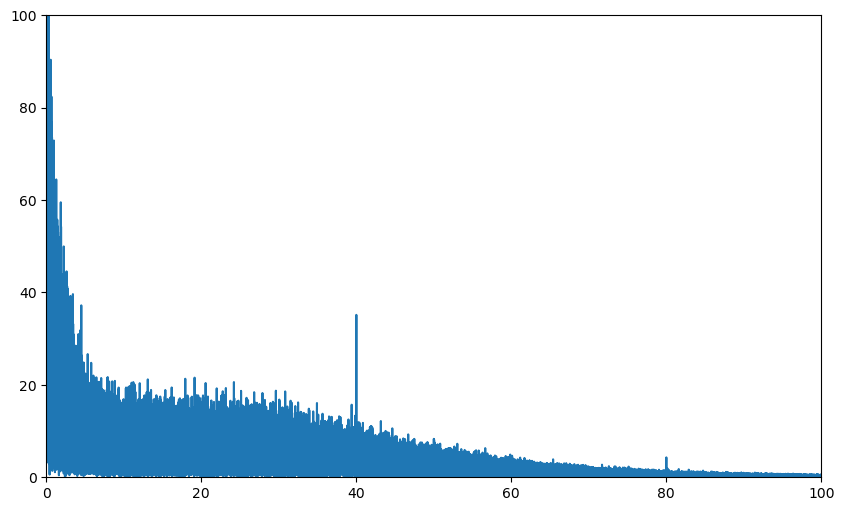

In [185]:
from scipy.fft import rfft, rfftfreq

spec = rfft(photometry_dict['analog_1_filt'])
freq = rfftfreq(len(photometry_dict['analog_1_filt']), 1 / photometry_dict['sampling_rate'])

plt.plot(freq, np.abs(spec))
plt.xlim([0,100])
plt.ylim([0,100])
plt.show()

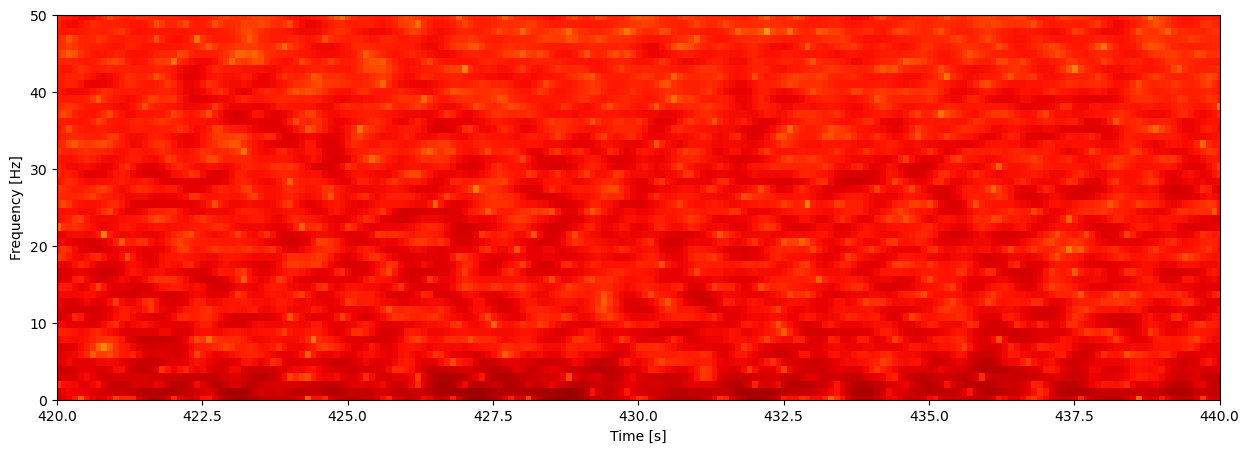

In [186]:
from scipy import signal
nperseg = 1024
noverlap = nperseg-100

freqs, times, Sx = signal.spectrogram(photometry_dict['analog_1_filt'], fs=photometry_dict['sampling_rate'], window='hanning',
                                      nperseg=nperseg, noverlap=noverlap,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(15, 5))
ax.pcolormesh(times, freqs, 10 *  np.log10(Sx), cmap='jet')
ax.set_ylim([0, 50])
ax.set_xlim(xlim)
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]');

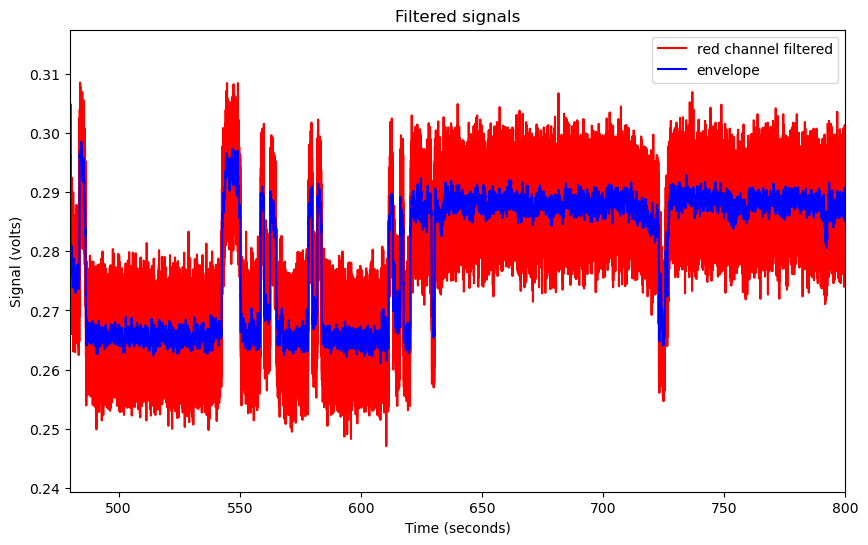

In [207]:
from scipy.stats import zscore
from scipy.signal import medfilt, hilbert

# z= hilbert(medfilt(photometry_dict['analog_2'],3)) #form the analytical signal
# inst_amplitude = np.abs(z) #envelope extraction
plt.plot(time, medfilt(photometry_dict['analog_2'],3), 'r', label='red channel filtered')
plt.plot(time, medfilt(photometry_dict['analog_2'],101), 'b', label='envelope')
# plt.plot(time, zscore(medfilt(photometry_dict['analog_2'],3)), 'orange', label='red channel filtered')


plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

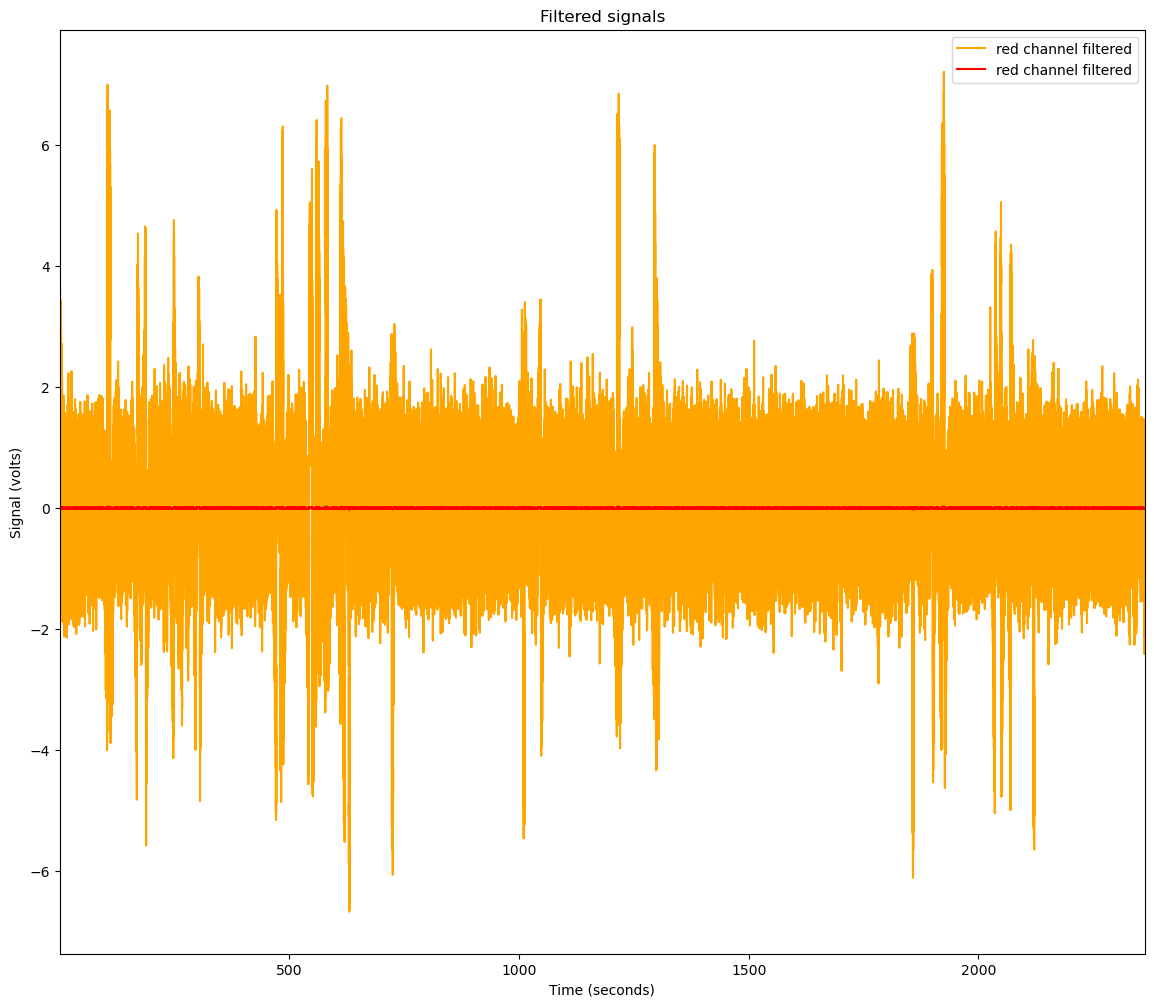

In [105]:
from scipy.stats import zscore
from scipy.signal import medfilt
xlim = [100,300]


plt.plot(time, zscore(photometry_dict['analog_2_filt']), 'orange', label='red channel filtered')
plt.plot(time, photometry_dict['analog_2_filt'], 'r', label='red channel filtered')


plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

# plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

In [461]:
# slope, intercept, r_value, p_value, std_err = linregress(x=TdTom_highpass, y=GCaMP_highpass)

# plt.scatter(TdTom_highpass[::5], GCaMP_highpass[::5],alpha=0.1, marker='.')
# x = np.array(plt.xlim())
# plt.plot(x, intercept+slope*x)
# plt.xlabel('TdTomato')
# plt.ylabel('GCaMP')
# plt.title('TdTomato - GCaMP correlation.')

# print('Slope    : {:.3f}'.format(slope))
# print('R-squared: {:.3f}'.format(r_value**2))

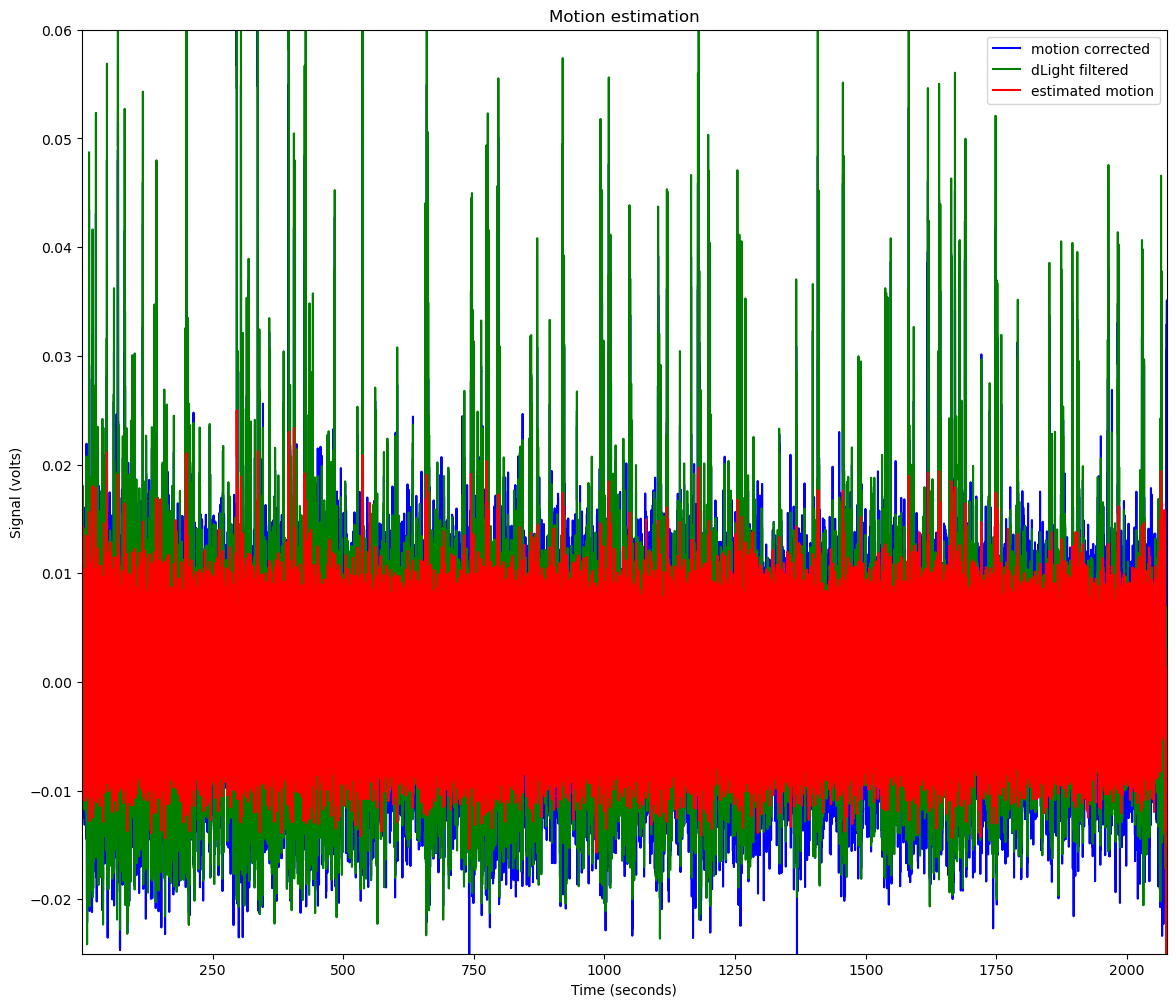

In [16]:
ylim = [-0.025, 0.06]

plt.plot(time, photometry_dict['analog_1_corrected'], 'b', label='motion corrected')
plt.plot(time, photometry_dict['analog_1_filt'], 'g', label='dLight filtered')
plt.plot(time, photometry_dict['analog_1_est_motion'], 'r', label='estimated motion')

plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Motion estimation')

# plt.xlim(xlim)
plt.ylim(ylim)
plt.legend();

### Define conditions and groups for extraction

In [17]:
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 'success': False, 'reward free': False, 'button_press': False}
conditions_dict3 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': True, 'reward free': False, 'button_press': False}
conditions_dict4 = {'trigger': 'CS_NoGo', 'valid': True, 'success': True, 'button_press': False}
conditions_dict5 = {'trigger': 'CS_NoGo', 'valid': True, 'success': False, 'button_press': False}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2, conditions_dict3, conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Go hit', 'Go miss', 'Go hit error', 'NoGo hit', 'NoGo miss']
# Groups as a list of lists
groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

### Extract Photometry trials and create a Continuous_Dataset

In [19]:
cont_dataset = exp_cohort.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'reaching_go_nogo', #'reaching_go_nogo',
        trig_on_ev = None, # align to the first event of a kind e.g. bar_off
        high_pass = 0.05, 
        low_pass = 45, 
        median_filt = 3,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 5, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f', 'analog_1_est_motion', 'analog_1_corrected'],
        verbose = False)

cont_dataset.set_trial_window(trial_window, 'ms')


No trial in any condition for subject 289 at: 2022-01-13 11:29:37
No trial in any condition for subject 291 at: 2022-01-12 16:26:30
No trial in any condition for subject 294 at: 2022-01-19 13:28:59
No trial in any condition for subject 294 at: 2022-03-15 13:41:23
No trial in any condition for subject 295 at: 2022-01-12 17:15:29
No trial in any condition for subject 300 at: 2022-06-27 14:32:03
No trial in any condition for subject 301 at: 2022-06-07 16:13:08
No trial in any condition for subject 305 at: 2022-05-18 14:28:34
No trial in any condition for subject 306 at: 2022-05-30 12:54:56
No trial in any condition for subject 307 at: 2022-06-28 17:59:38


In [12]:
cont_dataset.conditions

[{'success': True}, {'success': False}]

### Save Photometry Dataset

In [20]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs'
cont_dataset.save(folder_path, 'photo_reaching_gonogo_mf3_hp0.05_lp45')

Dataset saved in C:\Users\phar0732\Documents\GitHub\trialexp\outputs\photo_reaching_gonogo_mf3_hp0.05_lp45.pkl
data size is 956.0059967041016 Mb


### Reload a pre-existing dataset

In [21]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\photo_reaching_gonogo_mf3_hp0.05_lp45.pkl'
cont_dataset = load_dataset(dataset_full_path)

Export to sktime (pandas panel format instead of numpy)

In [27]:
X, y = cont_dataset.export_to_sktime(folder = folder_path, name = 'sktime_gonogo')

Nested Dataframe saved in C:\Users\phar0732\Documents\GitHub\trialexp\outputs\sktime_gonogo.pkl
sktime-format data size: 966.1635589599609 Mb


Load sktime transformed dataset

In [7]:
import pickle
fullpath = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\sktime_gonogo.pkl'
with open(fullpath, 'rb') as file:
    dataset = pickle.load(file)

In [9]:
X,y = dataset.export_to_sktime(name=fullpath)

Nested Dataframe saved in C:\Users\phar0732\Documents\GitHub\trialexp\outputs\sktime_gonogo.pkl.pkl.pkl
sktime-format data size: 966.1635589599609 Mb


In [25]:
X1 = X.loc[0:1000,('analog_1_est_motion', 'analog_1', 'analog_1_filt')]

Extracting features

In [ ]:
!pip install tsfresh

In [27]:
!pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=1a1676ccaf038c82c0adf4262f021b7905a3bc167dc9ec8de63c1216299d1068
  Stored in directory: c:\users\phar0732\appdata\local\pip\cache\wheels\d4\13\91\2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap


In [19]:
from sklearn.ensemble import RandomForestClassifier

from sktime.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

tsfresh_trafo = TSFreshFeatureExtractor(default_fc_parameters="minimal")


In [26]:
X1transfo = tsfresh_trafo.fit_transform(X1)

Feature Extraction: 100%|██████████| 3003/3003 [00:02<00:00, 1335.24it/s]


In [32]:
X1transfo.values

array([[ 3.38944835e+02,  2.11262173e-01,  2.11840522e-01, ...,
         2.73976414e-02,  2.73976414e-02, -1.44687183e-02],
       [ 3.39898681e+02,  2.11754329e-01,  2.12436676e-01, ...,
         1.48882519e-02,  1.48882519e-02, -1.10816188e-02],
       [ 3.37453890e+02,  2.10297365e-01,  2.10908681e-01, ...,
         1.69663863e-02,  1.69663863e-02, -1.23529576e-02],
       ...,
       [ 5.94841989e+02,  3.71780484e-01,  3.71776243e-01, ...,
         6.38317590e-03,  7.10407331e-03, -7.10407331e-03],
       [ 6.42637969e+02,  4.01952731e-01,  4.01648730e-01, ...,
         6.13721193e-03,  9.83829749e-03, -9.83829749e-03],
       [ 6.39976448e+02,  4.00089829e-01,  3.99985280e-01, ...,
         8.35540346e-03,  9.41268680e-03, -9.41268680e-03]])

In [66]:
from sklearn.manifold import TSNE

# n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

t_sne = TSNE(
    n_components=n_components,
    learning_rate="auto",
    perplexity=20,
    n_iter=1000,
    init="random",
    random_state=42,
)

X1_tsfresh_t_sne = t_sne.fit_transform(X1transfo.values)


In [67]:
X1_tsfresh_t_sne.shape

(1001, 2)

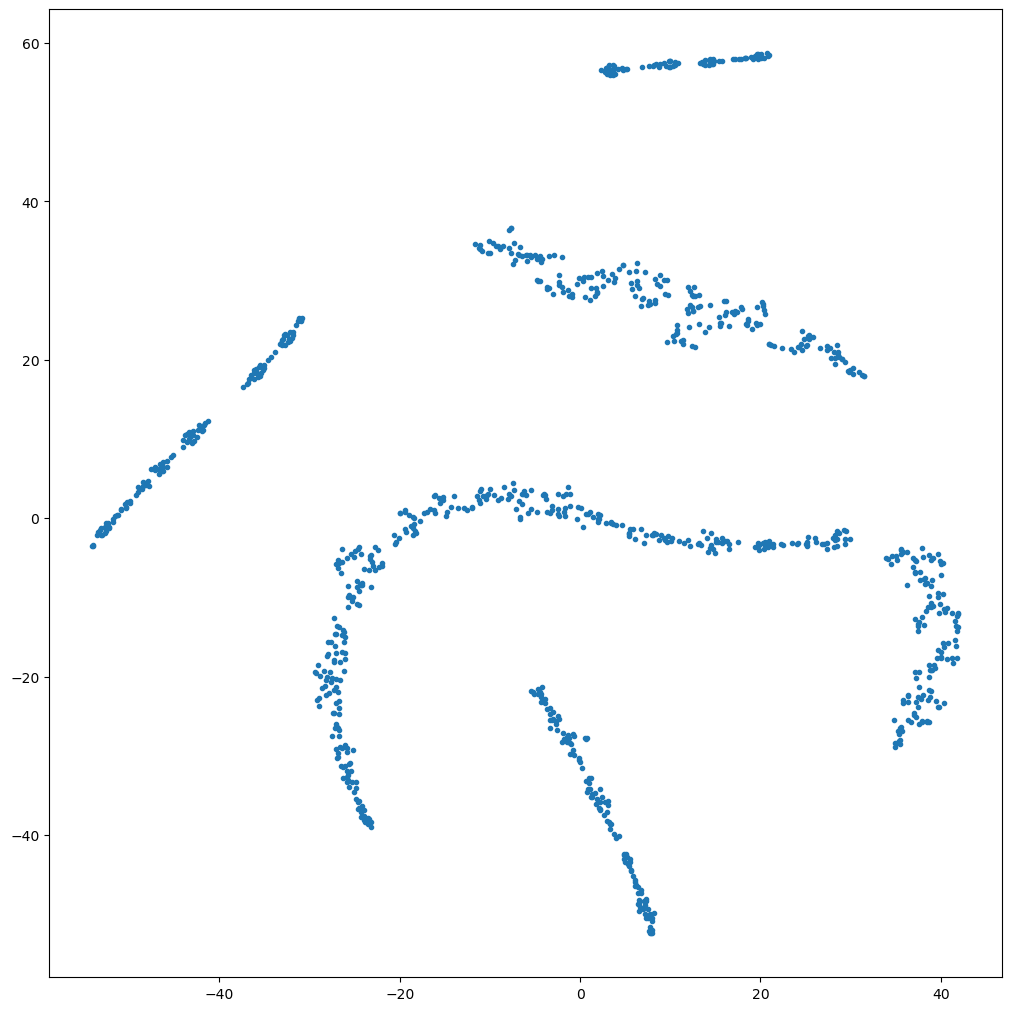

In [68]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10), facecolor="white", constrained_layout=True)
plt.scatter(X1_tsfresh_t_sne[:,0], X1_tsfresh_t_sne[:,1], marker='.')

### Optional methods

In [38]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([0,1, 52])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
# cont_dataset.filter_min(min_trials = 7)

# To remove subjects who do not have
# trials in all the conditions
# cont_dataset.filter_if_not_in_all_cond()


### Plot the photometry by condition

cond_ID: 0, group_idx 0, subj 280
cond_ID: 0, group_idx 0, subj 282
cond_ID: 0, group_idx 0, subj 289
cond_ID: 0, group_idx 0, subj 290
cond_ID: 0, group_idx 0, subj 291
cond_ID: 0, group_idx 0, subj 292
cond_ID: 0, group_idx 0, subj 293
cond_ID: 0, group_idx 0, subj 294
cond_ID: 0, group_idx 0, subj 295
cond_ID: 0, group_idx 0, subj 296
cond_ID: 0, group_idx 0, subj 297
cond_ID: 0, group_idx 0, subj 299
cond_ID: 0, group_idx 0, subj 300
cond_ID: 0, group_idx 0, subj 301
cond_ID: 0, group_idx 0, subj 303
cond_ID: 0, group_idx 0, subj 304
cond_ID: 0, group_idx 0, subj 305
cond_ID: 0, group_idx 0, subj 306
cond_ID: 0, group_idx 0, subj 307
cond_ID: 1, group_idx 0, subj 280
cond_ID: 1, group_idx 0, subj 282
cond_ID: 1, group_idx 0, subj 289
cond_ID: 1, group_idx 0, subj 290
cond_ID: 1, group_idx 0, subj 291
cond_ID: 1, group_idx 0, subj 292
cond_ID: 1, group_idx 0, subj 293
cond_ID: 1, group_idx 0, subj 294
cond_ID: 1, group_idx 0, subj 295
cond_ID: 1, group_idx 0, subj 296
cond_ID: 1, gr

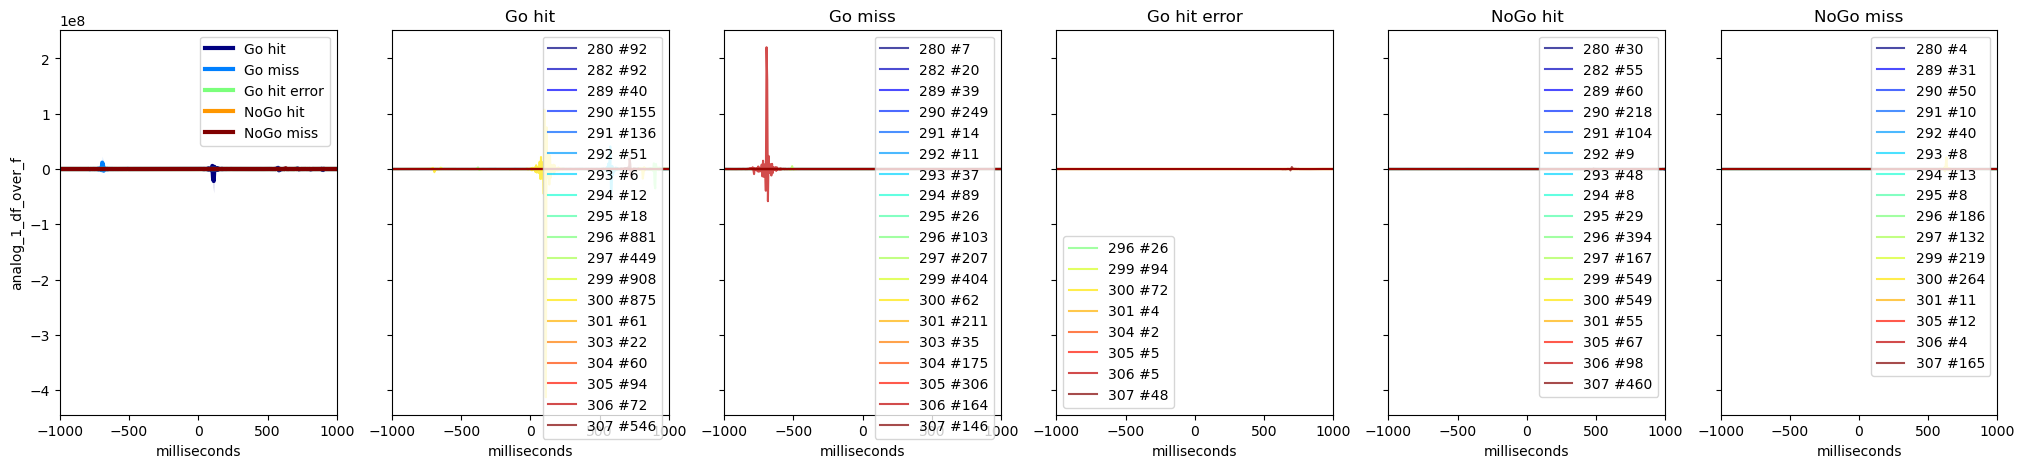

True    11188
Name: keep, dtype: int64

In [22]:
# if this was not set at creation
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-1000, 1000],
    time_unit = 'milliseconds',
    ylim =  None,# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = True,
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    figsize = (25, 5),
    dpi = 100,
    verbose = True)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()



In [87]:
cont_dataset.get_groups()

array([array([280, 282, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300,
              301, 303, 304, 305, 306, 307], dtype=int64)                     ],
      dtype=object)

### Optional methods

In [303]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


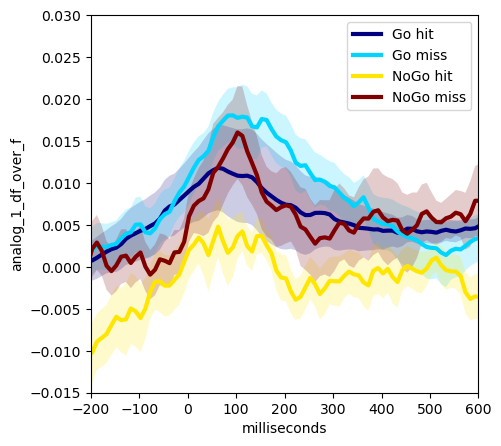

In [304]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)


In [305]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Optional methods

In [306]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


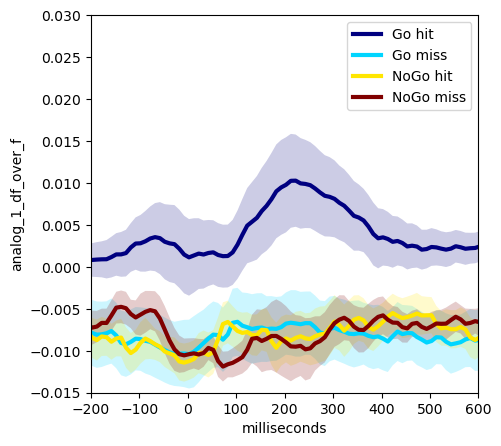

In [307]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)
